In [88]:
####Duration time separation model####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from scipy.stats import norm
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize

#np.random.seed(98537)

In [89]:
####データの生成####
##データの設定
s = 2
unit = 5
hh = 10000

In [90]:
##パラメータの生成
#セグメント割当の生成
pi = np.array([0.6])
z = np.random.binomial(1, pi, hh)
index_z1 = np.array(np.where(z==1)[0], dtype="int")
index_z2 = np.array(np.where(z==0)[0], dtype="int")
hh1 = index_z1.shape[0]
hh2 = index_z2.shape[0]

#モデルパラメータの生成
kappa = np.array([4.0, 1.0])
theta = np.array([1.0, 2.0])
phi = np.array([0.7, 0.2]) 

In [91]:
##応答変数の生成
#継続時間の生成
y1 = np.repeat(0.0, hh)
y1[index_z1] = np.random.gamma(kappa[0], 1/theta[0], hh1)
y1[index_z2] = np.random.gamma(kappa[1], 1/theta[1], hh2)

#ユニット接触回数の生成
y2 = np.repeat(0, hh)
y2[index_z1] = np.random.binomial(unit, phi[0], hh1)
y2[index_z2] = np.random.binomial(unit, phi[1], hh2)
y2[y2==0] = 1

(array([3.167e+03, 1.090e+03, 8.910e+02, 9.460e+02, 9.620e+02, 8.740e+02,
        6.760e+02, 4.720e+02, 3.050e+02, 2.200e+02, 1.460e+02, 1.020e+02,
        6.400e+01, 3.600e+01, 2.100e+01, 1.100e+01, 8.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        2.000e+00]),
 array([ 0.        ,  0.748299  ,  1.496598  ,  2.24489699,  2.99319599,
         3.74149499,  4.48979399,  5.23809299,  5.98639199,  6.73469098,
         7.48298998,  8.23128898,  8.97958798,  9.72788698, 10.47618598,
        11.22448497, 11.97278397, 12.72108297, 13.46938197, 14.21768097,
        14.96597997, 15.71427896, 16.46257796, 17.21087696, 17.95917596,
        18.70747496]),
 <a list of 25 Patch objects>)

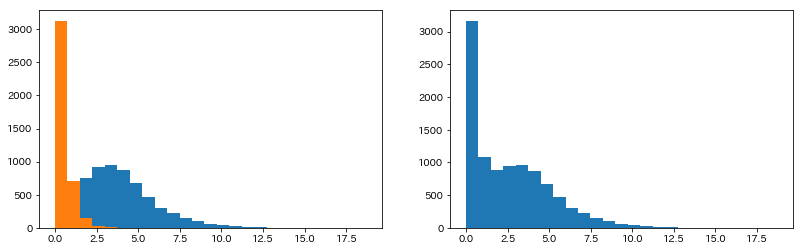

In [92]:
#応答変数の可視化
fig = plt.figure(figsize=(13.5, 4.0))
ax1 = fig.add_subplot(1, 2, 1); ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(y1[index_z1], bins=25, range=[0.0, np.max(y1)])
ax1.hist(y1[index_z2], bins=25, range=[0.0, np.max(y1)])
ax2.hist(y1, bins=25, range=[0.0, np.max(y1)])

In [93]:
####EMアルゴリズムでパラメータを推定####
##パラメータを推定するための関数
#観測データの尤度と潜在変数zを計算する関数
def ollz(kappa, theta, phi, pi, y1, y2, value):
    #モデルごとの尤度を定義
    Lho11 = scipy.stats.gamma.pdf(y1, kappa[0], scale=1/theta[0])
    Lho12 = scipy.stats.gamma.pdf(y1, kappa[1], scale=1/theta[1])
    Lho21 = scipy.stats.binom.pmf(y2, unit, phi[0])
    Lho22 = scipy.stats.binom.pmf(y2, unit, phi[1])
    Lho11[Lho11==0.0] = value; Lho12[Lho12==0.0] = value

    #観測データの対数尤度
    Lho = np.hstack(((pi*Lho11*Lho21)[:, np.newaxis], (1-pi)*(Lho12*Lho22)[:, np.newaxis]))
    LLobz = np.sum(np.log(np.sum(Lho, axis=1)))

    #潜在変数zの定義
    z = Lho / np.sum(Lho, axis=1)[:, np.newaxis]
    return LLobz, z

#完全データの対数尤度関数
def cll(theta, z, y):
    #パラメータの定義
    alpha = np.exp(theta[:s])
    beta = np.exp(theta[s:])

    #重み付き対数尤度の和
    y_vec = y[:, np.newaxis]
    LL = np.sum(z * (alpha*np.log(beta) - scipy.special.loggamma(alpha) + (alpha-1)*np.log(y_vec) - beta*y_vec))
    return -LL 

#完全データの対数微分関数
def dll(theta, z, y):
    #パラメータの定義
    alpha = np.exp(theta[:s])
    beta = np.exp(theta[s:])

    #勾配ベクトル
    y_vec = y[:, np.newaxis]
    sc1 = np.sum(z * (np.log(beta) - scipy.special.digamma(alpha) + np.log(y_vec)), axis=0)
    sc2 = np.sum(z * (alpha*(1/beta) - y_vec), axis=0)
    return -np.append(sc1, sc2)

In [94]:
##EMアルゴリズムの設定
iters = 0
rp = 200   #最大繰り返し数
LL = -1000000000   #対数尤度の初期値
dl = 100   #EMアルゴリズムの対数尤度の差の初期値
tol = 0.1
value = np.power(10.0, -200)
maxit = 20   #準ニュートン法のステップ数

In [95]:
##EMアルゴリズムの初期値
#混合率と潜在変数の初期値
pi = np.array([1/s])
zpt = np.repeat(pi, hh)

#パラメータの初期値
kappa = np.random.uniform(0.5, 3.0, s)
theta = np.random.uniform(0.5, 2.0, s)
phi = np.random.beta(25.0, 25.0, s)

In [96]:
#観測データの対数尤度と潜在変数
oll = ollz(kappa, theta, phi, pi, y1, y2, value)
zpt = oll[1]
LL1 = oll[0]

In [97]:
##EMアルゴリズムでパラメータを推定
while abs(dl) >= tol:
    #Mステップで完全データ対数尤度を最大化
    res = optimize.minimize(cll, np.log(np.append(kappa, theta)), jac=dll, method="BFGS", args=(zpt, y1), options={"disp": False})
    kappa = np.exp(res.x[:s])
    theta = np.exp(res.x[s:])
    phi = np.sum(zpt*y2[:, np.newaxis], axis=0) / np.sum(unit*zpt, axis=0)

    #混合率を更新
    pi = np.sum(zpt[:, 0]) / hh

    #Eステップで観測データの対数尤度と潜在変数zを更新
    oll = ollz(kappa, theta, phi, pi, y1, y2, value)
    zpt = oll[1]
    LL = oll[0]

    #EMアルゴリズムのパラメータを更新
    iters = iters + 1
    dl = LL - LL1
    LL1 = LL
    print(LL)

-36987.92972368733
-35939.65317464653
-34425.71076694069
-33510.25921530997
-32953.52172395944
-32678.4458486933
-32593.191057347656
-32546.646980255402
-32512.508299089815
-32473.89268803243
-32451.66868065518
-32432.87364748295
-32419.42007099949
-32403.254778335948
-32392.52307747033
-32384.39965983826
-32378.632173829687
-32370.824014612692
-32366.75015279527
-32361.972369666186
-32358.366814521873
-32355.58365636531
-32353.328738076754
-32351.45209012276
-32349.869755627416
-32348.52793752
-32347.38761052629
-32346.431815177086
-32345.646543159877
-32344.9607554178
-32344.344658658854
-32343.85427480745
-32343.43459109999
-32343.06375723784
-32342.768028198465
-32342.515664956623
-32342.293279059828
-32342.119007320056
-32341.973670828604
-32341.8537699351
-32341.75522825013


In [98]:
#推定結果のパラメータから乱数を生成
y11 = np.random.gamma(kappa[0], 1/theta[0], int(hh*pi))
y12 = np.random.gamma(kappa[1], 1/theta[1], int(hh*(1-pi)))
result_y1 = np.append(y11, y12)
index_z1 = np.arange(y11.shape[0])
index_z2 = np.max(index_z1) + np.arange(y12.shape[0]) + 1

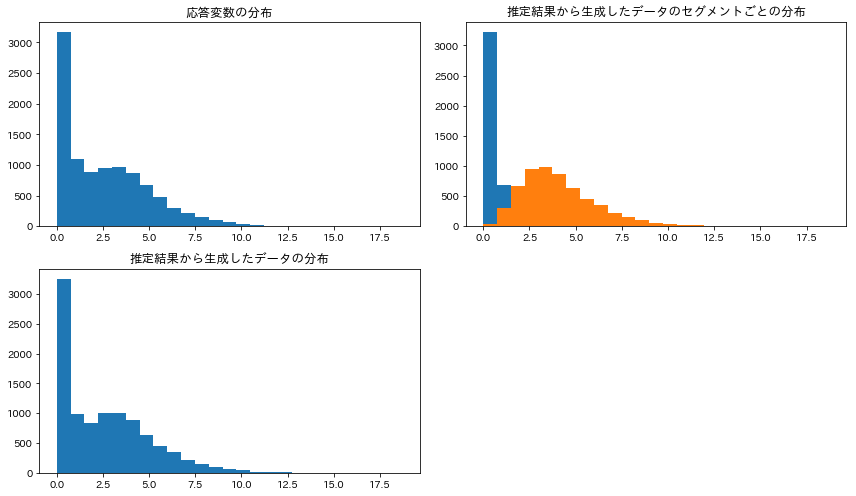

In [99]:
#推定結果と元データを可視化
fig = plt.figure(figsize=(12.0, 7.0))
legend = ["応答変数の分布", 
          "推定結果から生成したデータのセグメントごとの分布", "推定結果から生成したデータの分布"]
ax1 = fig.add_subplot(2, 2, 1); ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax1.hist(y1, bins=25, range=[0.0, np.max(y1)])
ax1.set_title(legend[0], fontsize=12.5)
ax2.hist(result_y1[index_z1], bins=25, range=[0.0, np.max(y1)])
ax2.hist(result_y1[index_z2], bins=25, range=[0.0, np.max(y1)])
ax2.set_title(legend[1], fontsize=12.5)
ax3.hist(np.append(y11, y12), bins=25, range=[0.0, np.max(y1)])
ax3.set_title(legend[2], fontsize=12.5)
fig.tight_layout()